# Main Results

This notebook reproduces the main figures from the manuscript:
- **Fig 3**: 3D perceptual accuracy, model confidence → human accuracy, model solution layer → human RT
- **Fig S1**: All models accuracy comparison
- **Fig S2**: Per-condition accuracy bars with example stimuli
- **Fig S3**: Per-condition human vs model scatter
- **Fig S4**: Confidence rank → accuracy & RT
- **Fig S5**: Granularity sensitivity analysis
- **Fig S6**: RT-accuracy by solution layer; confidence vs solution time

**Prerequisites**: Run `python scripts/run_evaluation.py --gpu_id <GPU>` first to generate the CSVs.

In [1]:
import sys
sys.path.insert(0, "..")

import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy import stats
from datasets import load_dataset

from human_multiview.config import RESULTS_DIR, N_LAYERS, MOCHI_DATASET

## Load evaluation results

In [ ]:
# Load CSVs generated by run_evaluation.py
df_conf = pd.read_csv(RESULTS_DIR / "all_models_confidence.csv")
df_layers = pd.read_csv(RESULTS_DIR / "vggt_layer_analysis.csv")

# Load MOCHI dataset for DINOv2 baseline (SVM-based, already chance-normalized)
hf_mochi = load_dataset(MOCHI_DATASET)['train']
df_dino_hf = pd.DataFrame({
    'trial_name': hf_mochi['trial'],
    'dino': hf_mochi['DINOv2G_avg'],
    'dataset': hf_mochi['dataset'],
})
df_dino_hf = df_dino_hf[df_dino_hf['dataset'] != 'hvm'].drop(columns='dataset')

# Merge all results into a single trial-level dataframe
df = df_conf.merge(df_dino_hf, on="trial_name", how="left")
df = df.merge(
    df_layers[["trial_name",
               "earliest_reliable_layer_mean", "earliest_reliable_layer_max",
               "earliest_reliable_layer_global_pool"]],
    on="trial_name", how="left"
)

# Merge shapegen subconditions (abstract0-4) into a single 'shapegen' condition
df.loc[df['dataset'] == 'shapegen', 'condition'] = 'shapegen'

# Create short aliases matching the manuscript analysis code
# Use max_masked metric for VGGT (matches original manuscript's max-of-depth-confidence)
df["human"] = df["human_accuracy"]
df["vggt"] = df["vggt_max_masked_correct"].astype(int)
# df["dino"] already set from MOCHI DINOv2G_avg (already chance-normalized)
df["confidence_margin"] = df["vggt_max_masked_margin"]
df["early_layer_mean"] = df["earliest_reliable_layer_mean"]
df["early_layer_max"] = df["earliest_reliable_layer_max"]
df["early_layer_pool"] = df["earliest_reliable_layer_global_pool"]

# Other models: metric choice matches the original manuscript evaluation
# - Pi3 / DUST3R: max_unmasked of depth confidence
# - MASt3R: mean_masked of descriptor confidence (desc_conf via model wrapper)
for model in ["pi3", "dust3r"]:
    df[model] = df[f"{model}_max_unmasked_correct"].astype(int)
df["mast3r"] = df["mast3r_mean_masked_correct"].astype(int)

# Fill NaN solution layers: 24 if confidence correct, 25 if wrong
# (NaN = no reliable intermediate layer was found)
for col in ["early_layer_mean", "early_layer_max", "early_layer_pool"]:
    for idx in df[df[col].isna()].index:
        df.at[idx, col] = 24 if df.at[idx, "vggt"] else 25

print(f"Loaded {len(df)} trials")
print(f"Datasets: {sorted(df.dataset.unique())}")
print(f"Conditions ({len(df.condition.unique())}): {sorted(df.condition.unique())}")

## Colors, normalization, and condition-level statistics

In [ ]:
# Manuscript color palette
colors = {
    'human': '#F5AD18',
    'vggt': "#AE0E61",
    'dino': "#A6A4A4",
    'pi3': '#9E1C60',
    'dust3r': '#811844',
    'mast3r': '#811844',
}

# Inferno colormap variant (used for Fig 3 main panels)
_CMAP_ = 'inferno'
colors_main = {
    'human': mpl.colormaps[_CMAP_](.8),
    'vggt': mpl.colormaps[_CMAP_](.5),
    'dino': 'lightgrey',
}


def normalize(x, dataset):
    """
    Normalize performance between 0 and 1 regardless of original scale.
    Accounts for different chance levels across datasets (4-AFC vs 3-AFC).
    """
    chance = {'barense': 1/4, 'shapegen': 1/3, 'shapenet': 1/3}[dataset]
    possible = 1 - chance
    actual = np.array(x) - chance
    adjusted = actual / possible
    return adjusted


def denormalize(adjusted, dataset):
    """Inverse of normalize: converts normalized values back to original scale."""
    chance = {'barense': 1/4, 'shapegen': 1/3, 'shapenet': 1/3}[dataset]
    possible = 1 - chance
    actual = adjusted * possible
    x = actual + chance
    return x


# Create condition-level normalized means
# human_accuracy from MOCHI is already chance-normalized
# DINOv2G_avg from MOCHI is already chance-normalized (SVM-based evaluation)
# Model binary columns need normalization
results_columns = ['human', 'vggt', 'dino', 'pi3', 'dust3r', 'mast3r', 'confidence_margin']

df_norm = df.groupby(['dataset', 'condition'], as_index=False)[results_columns].mean()
df_std = df.groupby(['dataset', 'condition'], as_index=False)[results_columns].sem()

already_normalized = ['human', 'dino']

for col in results_columns:
    if col not in already_normalized:
        names = df_norm.dataset
        numbers = df_norm[col]
        df_norm[col] = [normalize(numbers[i], names[i]) for i in range(len(names))]
    df_norm[col + '_std'] = df_std[col]

# Add RT
df_norm['rt'] = df.groupby(['dataset', 'condition'], as_index=False)[['human_rt']].mean().values[:, -1]
df_norm['rt_std'] = df.groupby(['dataset', 'condition'], as_index=False)[['human_rt']].sem().values[:, -1]

print(f"Conditions: {len(df_norm)}")
print(f"Overall normalized accuracy:")
for m in ['human', 'vggt', 'dino', 'pi3', 'dust3r', 'mast3r']:
    print(f"  {m:>8s}: {df_norm[m].mean():.3f} ± {df_norm[m].sem():.3f}")

## Fig 3: Main results (3-panel figure)

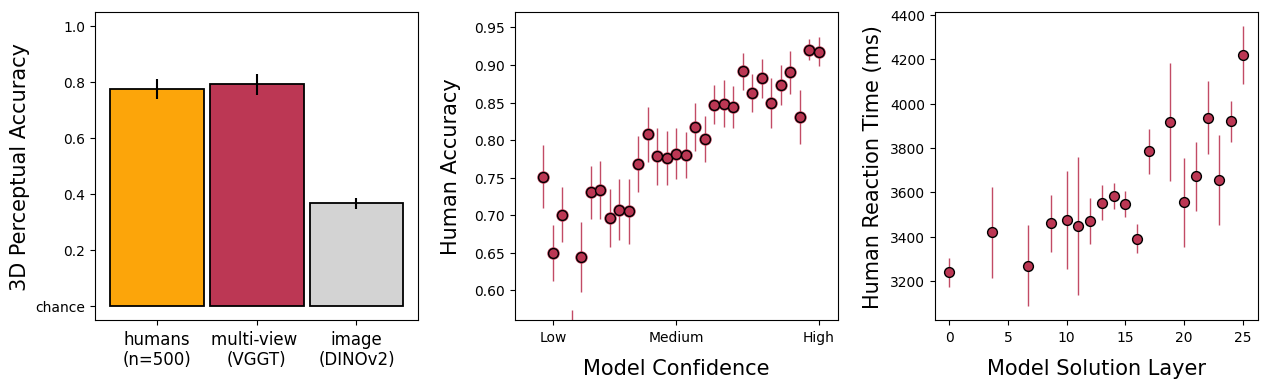

Confidence → Accuracy: r=0.783, p=3.23e-07
Solution layer → RT:   r=0.826, p=1.35e-05


In [21]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=[15, 4])

# --- Panel 1: Overall accuracy ---
show_results_for = ['human', 'vggt', 'dino']
n_models = len(show_results_for)

for i_plot, i_model in enumerate(show_results_for):
    x_location = (i_plot) / n_models
    y_values = df_norm[i_model].mean()
    y_error = df_norm[i_model].sem()

    ax1.bar(x_location, y_values, color=colors_main[i_model],
            width=(1/n_models) - .02, edgecolor='black', linewidth=1.3)
    ax1.errorbar(x_location, y_values, y_error, color='black', fmt='none')

ax1.set_xticks([0, 1/n_models, 2*(1/n_models)])
ax1.set_xticklabels(['humans\n(n=500)', 'multi-view \n(VGGT)', 'image\n(DINOv2)'], fontsize=12)
ax1.set_yticks([0, .2, .4, .6, .8, 1.0])
ax1.set_yticklabels(['chance', 0.2, 0.4, 0.6, 0.8, 1.0], fontsize=10)
ax1.set_ylim([-.05, 1.05])
ax1.set_ylabel('3D Perceptual Accuracy', fontsize=15)

# --- Panel 2: Model confidence → human accuracy ---
n_bins = 30
df['conf_bin'] = pd.qcut(df['confidence_margin'], q=n_bins, duplicates='drop')

bin_stats = df.groupby('conf_bin', observed=True).agg({
    'human_accuracy': ['mean', 'sem', 'count'],
    'vggt': ['mean', 'sem'],
    'confidence_margin': ['mean', 'sem'],
    'human_rt': ['mean', 'sem'],
    'dino': 'mean',
}).reset_index()

bin_stats.columns = ['conf_bin', 'human_acc_mean', 'human_acc_sem', 'n_trials',
                     'vggt_acc', 'vggt_sem', 'conf_mean', 'conf_sem',
                     'human_rt_mean', 'human_rt_sem', 'dino']
bin_stats = bin_stats.sort_values('conf_mean').reset_index(drop=True)
bin_stats['rank'] = range(1, len(bin_stats) + 1)

ax2.scatter(x=bin_stats['rank'], y=bin_stats['human_acc_mean'],
            s=50, color=colors_main['vggt'], edgecolor='black')
ax2.errorbar(x=bin_stats['rank'], y=bin_stats['human_acc_mean'],
             yerr=bin_stats['human_acc_sem'],
             fmt='o-', color=colors_main['vggt'], capsize=0, linewidth=1,
             markersize=8, linestyle='None', alpha=.9, zorder=-2)
ax2.set_xticks([2, 15, 30])
ax2.set_xticklabels(['Low', 'Medium', 'High'], fontsize=10)
ax2.set_ylim(.56, .97)
ax2.set_xlim(-2, 32)
ax2.set_ylabel('Human Accuracy', fontsize=15, labelpad=10)
ax2.set_xlabel('Model Confidence', fontsize=15, labelpad=10)

# --- Panel 3: Solution layer → human RT ---
n_bins = 100
df['layer_bin'] = pd.qcut(df['early_layer_max'], q=n_bins, duplicates='drop')

layer_stats = df.groupby('layer_bin', observed=True).agg({
    'human_accuracy': ['mean', 'sem', 'count'],
    'vggt': 'mean',
    'confidence_margin': ['mean', 'sem'],
    'human_rt': ['mean', 'sem'],
    'early_layer_max': 'mean',
}).reset_index()

layer_stats.columns = ['layer_bin', 'human_acc_mean', 'human_acc_sem', 'n_trials',
                       'vggt_acc', 'conf_mean', 'conf_sem',
                       'human_rt_mean', 'human_rt_sem', 'layer']
layer_stats = layer_stats.sort_values('layer_bin').reset_index(drop=True)
layer_stats['rank'] = range(1, len(layer_stats) + 1)

ax3.scatter(x=layer_stats['layer'], y=layer_stats['human_rt_mean'],
            s=50, color=colors_main['vggt'], edgecolor='black')
ax3.errorbar(x=layer_stats['layer'], y=layer_stats['human_rt_mean'],
             yerr=layer_stats['human_rt_sem'],
             fmt='o-', color=colors_main['vggt'], capsize=0, linewidth=1,
             linestyle='None', alpha=.9, zorder=-2)
ax3.set_ylabel('Human Reaction Time (ms)', fontsize=15, labelpad=5)
ax3.set_xlabel('Model Solution Layer', fontsize=15, labelpad=10)

plt.subplots_adjust(wspace=.3)
plt.savefig(RESULTS_DIR / "fig3_main.pdf", bbox_inches='tight')
plt.show()

# Statistical tests
r_conf, p_conf = stats.pearsonr(bin_stats['conf_mean'], bin_stats['human_acc_mean'])
r_layer, p_layer = stats.pearsonr(layer_stats['layer'], layer_stats['human_rt_mean'])
print(f"Confidence → Accuracy: r={r_conf:.3f}, p={p_conf:.2e}")
print(f"Solution layer → RT:   r={r_layer:.3f}, p={p_layer:.2e}")

## Fig S1: All models accuracy comparison

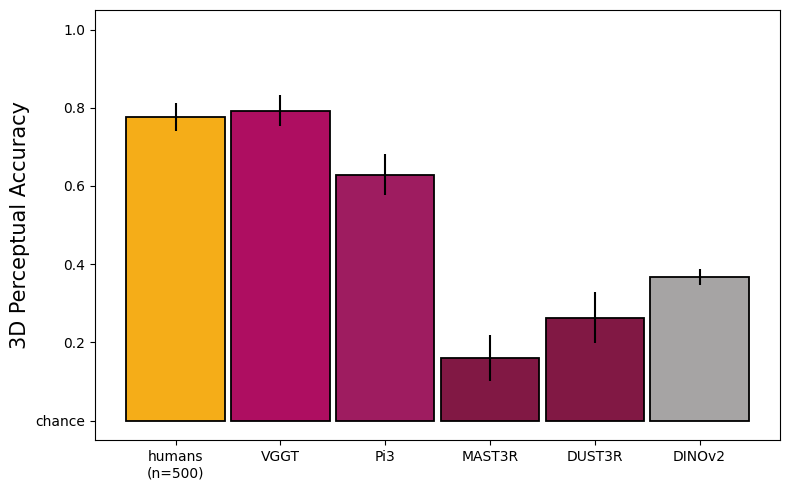

     human: 0.777 ± 0.035
      vggt: 0.793 ± 0.039
       pi3: 0.629 ± 0.053
    mast3r: 0.160 ± 0.059
    dust3r: 0.263 ± 0.065
      dino: 0.367 ± 0.021


In [13]:
fig, ax = plt.subplots(figsize=[8, 5])

show_results_for = ['human', 'vggt', 'pi3', 'mast3r', 'dust3r', 'dino']
labels = ['humans\n(n=500)', 'VGGT', 'Pi3', 'MAST3R', 'DUST3R', 'DINOv2']
n_models = len(show_results_for)

for i_plot, (i_model, label) in enumerate(zip(show_results_for, labels)):
    x_location = i_plot / n_models
    y_values = df_norm[i_model].mean()
    y_error = df_norm[i_model].sem()

    ax.bar(x_location, y_values, color=colors.get(i_model, '#888888'),
           width=(1/n_models) - .01, edgecolor='black', linewidth=1.3)
    ax.errorbar(x_location, y_values, y_error, color='black', fmt='none')

ax.set_xticks([i / n_models for i in range(n_models)])
ax.set_xticklabels(labels, fontsize=10)
ax.set_yticks([0, .2, .4, .6, .8, 1.0])
ax.set_yticklabels(['chance', 0.2, 0.4, 0.6, 0.8, 1.0], fontsize=10)
ax.set_ylim([-.05, 1.05])
ax.set_ylabel('3D Perceptual Accuracy', fontsize=15)

plt.tight_layout()
plt.savefig(RESULTS_DIR / "fig_s1_all_models.pdf", bbox_inches='tight')
plt.show()

# Print exact values
for model in show_results_for:
    print(f"  {model:>8s}: {df_norm[model].mean():.3f} ± {df_norm[model].sem():.3f}")

## Fig S2: Condition-level accuracy with example stimuli

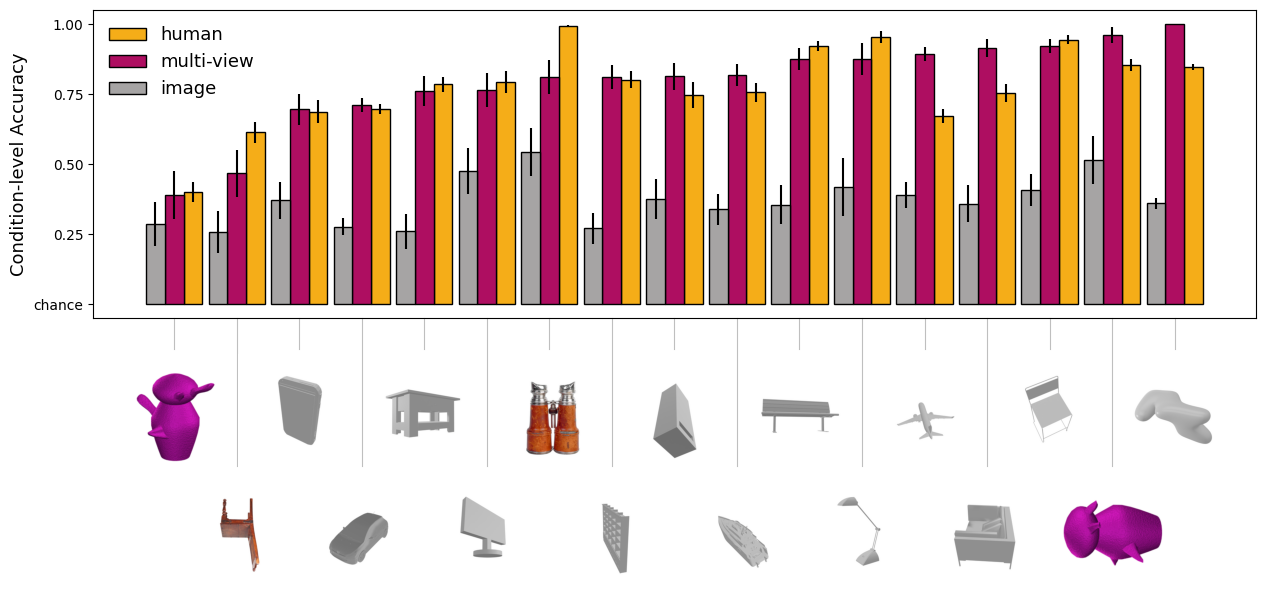

In [14]:
from PIL import Image
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from matplotlib.transforms import blended_transform_factory

# Load MOCHI dataset for example images
hf_mochi = load_dataset(MOCHI_DATASET)['train']

# Hand-selected image indices per condition (curated for visual clarity)
selected_indices = {
    'abstract_hisim': 5, 'familiar_hisim': 5, 'telephone': 5, 'car': 7,
    'table': 9, 'display': 4, 'loudspeaker': 6, 'watercraft': 1,
    'familiar_lowsim': 2, 'cabinet': 9, 'lamp': 1, 'sofa': 1,
    'airplane': 1, 'bench': 10, 'chair': 6, 'abstract_lowsim': 1, 'shapegen': 4,
}
default_index = 10

df_sorted = df_norm.sort_values(by='vggt')
unique_conditions = df_sorted.condition.values

# Load one example image per condition
image_list = []
for cond in unique_conditions:
    cond_lookup = 'abstract0' if cond == 'shapegen' else cond
    indices = [i for i, c in enumerate(hf_mochi["condition"]) if c == cond_lookup]
    chosen_idx = selected_indices.get(cond, default_index)
    idx = indices[min(chosen_idx, len(indices) - 1)]

    img_data = hf_mochi[idx]["images"]
    if isinstance(img_data, list):
        img_data = img_data[0]
    if not isinstance(img_data, Image.Image):
        img_data = Image.fromarray(img_data)
    image_list.append(img_data.resize((350, 350), Image.Resampling.LANCZOS))

# Plot staggered barplot
n = len(df_sorted)
fig, ax = plt.subplots(figsize=[15, 4])

plt.bar(x=[i + .3 for i in range(n)], height=df_sorted['human'], color=colors['human'],
        label='human', width=.3, edgecolor='black')
plt.bar(x=[i + 0 for i in range(n)], height=df_sorted['vggt'], color=colors['vggt'],
        label='multi-view', width=.3, edgecolor='black')
plt.bar(x=[i + -.3 for i in range(n)], height=df_sorted['dino'], color=colors['dino'],
        label='image', width=.3, edgecolor='black')

plt.errorbar(x=[i + .3 for i in range(n)], y=df_sorted['human'],
             yerr=df_sorted['human_std'], capsize=0, fmt='none', color='black')
plt.errorbar(x=[i + 0 for i in range(n)], y=df_sorted['vggt'],
             yerr=df_sorted['vggt_std'], capsize=0, fmt='none', color='black')
plt.errorbar(x=[i + -.3 for i in range(n)], y=df_sorted['dino'],
             yerr=df_sorted['dino_std'], capsize=0, fmt='none', color='black')

plt.yticks([0, .25, .50, .75, 1.0], ['chance', '0.25', '0.50', '0.75', '1.00'])
plt.ylim(-0.05, 1.05)
plt.ylabel('Condition-level Accuracy', fontsize=13)
plt.legend(loc=2, framealpha=0, fontsize=13)
plt.xticks([])

# Stagger images into two rows below the plot
zoom_factor = 0.25 if n < 20 else 0.22 if n < 50 else 0.18
trans = blended_transform_factory(ax.transData, ax.transAxes)
y_top = -0.12      # even indices
y_bottom = -0.5    # odd indices

for i, img in enumerate(image_list[:n]):
    y_pos = y_top if i % 2 == 0 else y_bottom
    imagebox = OffsetImage(img, zoom=zoom_factor, resample=True)
    ab = AnnotationBbox(imagebox, (i, y_pos), xycoords=trans, frameon=False,
                        box_alignment=(0.5, 1.0), clip_on=False)
    ax.add_artist(ab)
    ax.plot([i, i], [0.0, y_pos + 0.02], color='gray', linewidth=0.8,
            linestyle='-', alpha=0.5, transform=trans, clip_on=False, zorder=0)

plt.savefig(RESULTS_DIR / "fig_s2_condition_accuracy.pdf", bbox_inches='tight')
plt.show()

## Fig S3: Per-condition human vs model scatter

vggt: r=0.764
dino: r=0.580


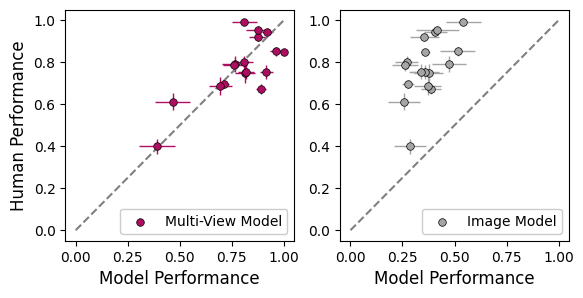

In [15]:
plt.figure(figsize=[6.5, 3])

for i_plot, i_model in enumerate(['vggt', 'dino']):
    plt.subplot(1, 2, i_plot + 1)

    x = df_norm[i_model]
    y = df_norm.human
    r = np.corrcoef(x, y)[0, 1]

    plt.scatter(x=x, y=y, color=colors[i_model], edgecolor='black', linewidth=.5, s=30,
                label={'vggt': 'Multi-View Model', 'dino': 'Image Model'}[i_model])
    plt.errorbar(x=df_norm[i_model], y=df_norm['human'],
                 yerr=df_norm['human_std'], xerr=df_norm[f'{i_model}_std'],
                 capsize=0, color=colors[i_model],
                 linewidth=1, linestyle='None', alpha=1, zorder=-2)
    plt.legend(loc=4, framealpha=1)
    plt.plot([0, 1], [0, 1], ls='--', color='gray', zorder=-1)
    plt.xlabel('Model Performance', fontsize=12)
    if not i_plot:
        plt.ylabel('Human Performance', fontsize=12)

    print(f"{i_model}: r={r:.3f}")

plt.savefig(RESULTS_DIR / "fig_s3_scatter.pdf", bbox_inches='tight')
plt.show()

## Fig S4: Confidence rank → accuracy & RT

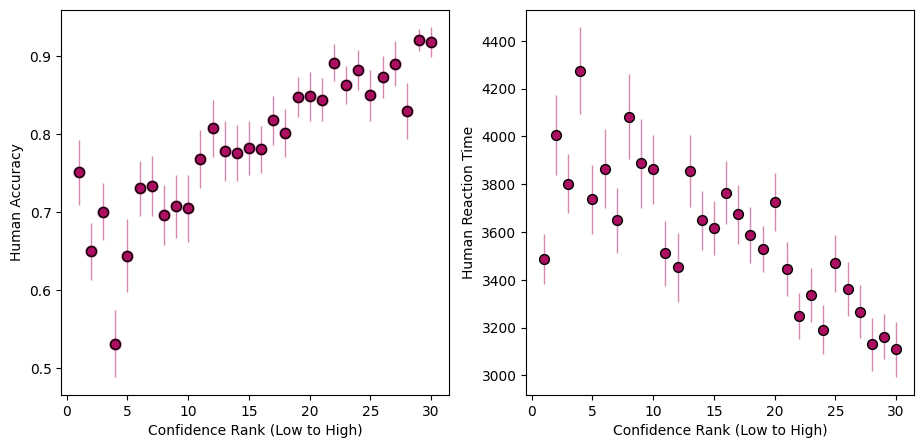

In [16]:
n_bins = 30
df['conf_bin'] = pd.qcut(df['confidence_margin'], q=n_bins, duplicates='drop')

bin_stats_s4 = df.groupby('conf_bin', observed=True).agg({
    'human_accuracy': ['mean', 'sem', 'count'],
    'vggt': 'mean',
    'confidence_margin': 'mean',
    'human_rt': ['mean', 'sem'],
    'early_layer_mean': 'mean',
}).reset_index()

bin_stats_s4.columns = ['conf_bin', 'human_acc_mean', 'human_acc_sem', 'n_trials',
                        'vggt_acc', 'conf_mean', 'human_rt_mean', 'human_rt_sem', 'layer']
bin_stats_s4 = bin_stats_s4.sort_values('conf_mean').reset_index(drop=True)
bin_stats_s4['rank'] = range(1, len(bin_stats_s4) + 1)

plt.figure(figsize=[11, 5])

plt.subplot(121)
plt.scatter(x=bin_stats_s4['rank'], y=bin_stats_s4['human_acc_mean'],
            s=50, color=colors['vggt'], edgecolor='black')
plt.errorbar(x=bin_stats_s4['rank'], y=bin_stats_s4['human_acc_mean'],
             yerr=bin_stats_s4['human_acc_sem'],
             fmt='o-', color=colors['vggt'], capsize=0, linewidth=1,
             markersize=8, linestyle='None', alpha=.5, zorder=-2)
plt.xlabel('Confidence Rank (Low to High)')
plt.ylabel('Human Accuracy')

plt.subplot(122)
plt.scatter(x=bin_stats_s4['rank'], y=bin_stats_s4['human_rt_mean'],
            s=50, color=colors['vggt'], edgecolor='black')
plt.errorbar(x=bin_stats_s4['rank'], y=bin_stats_s4['human_rt_mean'],
             yerr=bin_stats_s4['human_rt_sem'],
             fmt='o-', color=colors['vggt'], capsize=0, linewidth=1,
             linestyle='None', alpha=.5, zorder=-2)
plt.xlabel('Confidence Rank (Low to High)')
plt.ylabel('Human Reaction Time')

plt.savefig(RESULTS_DIR / "fig_s4_confidence_rank.pdf", bbox_inches='tight')
plt.show()

## Fig S5: Granularity sensitivity

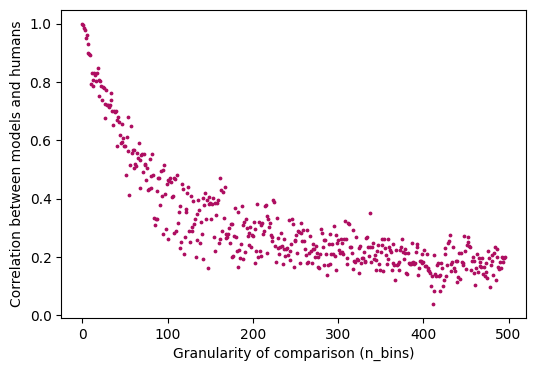

In [17]:
rs = []
for n_bins in range(3, 500):
    df_sorted_gran = df.sort_values('human').copy()
    try:
        df_sorted_gran['bin'] = pd.qcut(df_sorted_gran['human'], q=n_bins,
                                        labels=False, duplicates='drop')
        r = np.corrcoef(df_sorted_gran.groupby('bin')['vggt'].mean(),
                        y=df_sorted_gran.groupby('bin')['human'].mean())
        rs.append(r[0, 1])
    except Exception:
        rs.append(np.nan)

plt.figure(figsize=[6, 4])
plt.scatter(range(len(rs)), rs, s=3, color=colors['vggt'])
plt.xlabel('Granularity of comparison (n_bins)')
plt.ylabel('Correlation between models and humans')
plt.savefig(RESULTS_DIR / "fig_s5_granularity.pdf", bbox_inches='tight')
plt.show()

## Fig S6: RT-accuracy and confidence by solution layer

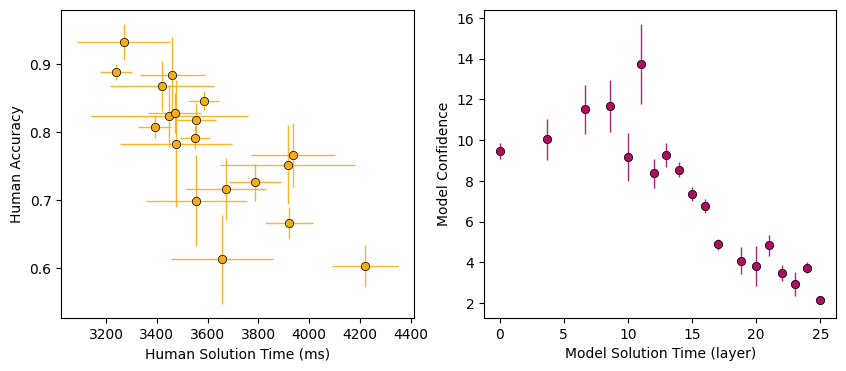

In [18]:
# Uses layer_stats computed in Fig 3

plt.figure(figsize=[10, 4])

plt.subplot(121)
plt.scatter(x=layer_stats['human_rt_mean'], y=layer_stats['human_acc_mean'],
            color=colors['human'], edgecolor='black', linewidth=.5)
plt.errorbar(x=layer_stats['human_rt_mean'], y=layer_stats['human_acc_mean'],
             yerr=layer_stats['human_acc_sem'], xerr=layer_stats['human_rt_sem'],
             fmt='o-', color=colors['human'], capsize=0, linewidth=1,
             markersize=5, linestyle='None', alpha=.9, zorder=-2)
plt.xlabel("Human Solution Time (ms)")
plt.ylabel('Human Accuracy')

plt.subplot(122)
plt.scatter(x=layer_stats['layer'], y=layer_stats['conf_mean'],
            color=colors['vggt'], edgecolor='black', linewidth=.5)
plt.errorbar(x=layer_stats['layer'], y=layer_stats['conf_mean'],
             yerr=layer_stats['conf_sem'],
             fmt='o-', color=colors['vggt'], capsize=0, linewidth=1,
             markersize=5, linestyle='None', alpha=.9, zorder=-2)
plt.xlabel("Model Solution Time (layer)")
plt.ylabel('Model Confidence')

plt.savefig(RESULTS_DIR / "fig_s6_rt_accuracy.pdf", bbox_inches='tight')
plt.show()